# Practice Session 05: Hubs and authorities


Author: <font color="black">Tània Pazos</font>

E-mail: <font color="black">tania.pazos01@estudiant.upf.edu</font>

Date: <font color="black">21/10/2023</font>

# 1. Read mapping of codes to country names

First of all, we will read into variable ``id2name`` the file containing the list of countries and territories. 

In [1]:
import csv
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
INPUT_NAMES_FILENAME = "data/trade-flows/trade-countries.csv"
INPUT_TRADE_OLD = "data/trade-flows/trade-2010-flows.csv"
YEAR_OLD = 2010
INPUT_TRADE_NEW = "data/trade-flows/trade-2021-flows.csv"
YEAR_NEW = 2021

In [3]:
id2name = {}

In [4]:
# Open a file for reading in text mode
with open(INPUT_NAMES_FILENAME, "rt") as input_file:
    # Create a CSV reader for a tab-delimited file with a header
    reader = csv.DictReader(input_file, delimiter='\t')
    
    # Iterate through records, each record is a dictionary
    for record in reader:
        id2name[record["code"]] = record["name"]
        print(record)

{'code': 'AUS', 'name': 'Australia'}
{'code': 'AUT', 'name': 'Austria'}
{'code': 'BEL', 'name': 'Belgium'}
{'code': 'CAN', 'name': 'Canada'}
{'code': 'CHE', 'name': 'Switzerland'}
{'code': 'CHL', 'name': 'Chile'}
{'code': 'CZE', 'name': 'Czech Republic'}
{'code': 'DEU', 'name': 'Germany'}
{'code': 'DNK', 'name': 'Denmark'}
{'code': 'ESP', 'name': 'Spain'}
{'code': 'EST', 'name': 'Estonia'}
{'code': 'FIN', 'name': 'Finland'}
{'code': 'FRA', 'name': 'France'}
{'code': 'GBR', 'name': 'United Kingdom'}
{'code': 'GRC', 'name': 'Greece'}
{'code': 'HUN', 'name': 'Hungary'}
{'code': 'IRL', 'name': 'Ireland'}
{'code': 'ISL', 'name': 'Iceland'}
{'code': 'ISR', 'name': 'Israel'}
{'code': 'ITA', 'name': 'Italy'}
{'code': 'JPN', 'name': 'Japan'}
{'code': 'LUX', 'name': 'Luxembourg'}
{'code': 'MEX', 'name': 'Mexico'}
{'code': 'NLD', 'name': 'Netherlands'}
{'code': 'NOR', 'name': 'Norway'}
{'code': 'NZL', 'name': 'New Zealand'}
{'code': 'POL', 'name': 'Poland'}
{'code': 'PRT', 'name': 'Portugal'}
{'c

And test the mapping.

In [5]:
print(id2name["DEU"])

Germany


# 2. Read flows data into two graphs

## 2.1. Read amount traded

Now, we will read the files `INPUT_TRADE_OLD` and `INPUT TRADE_NEW` as directed graphs into variables `gOld` and `gNew` respectively.

In [6]:
# Create the empty directed graph
gOld = nx.DiGraph()

# Open and read the INPUT_TRADE_OLD file
with open(INPUT_TRADE_OLD, "rt") as input_file:
    reader = csv.DictReader(input_file, delimiter = '\t')
    
    for record in reader:
        # Check if from_country and to_country in list of countries
        if record["from"] in id2name and record["to"] in id2name:
            w = round(float(record["amount"]) / 1e6 )# Convert to millions
            gOld.add_edge(record["from"], record["to"], weight = w)
                             
# Create the empty directed graph
gNew = nx.DiGraph()

# Open and read the INPUT_TRADE_NEW file
with open(INPUT_TRADE_NEW, "rt") as input_file:
    reader = csv.DictReader(input_file, delimiter = '\t')
    
    for record in reader:
        # Check if from_country and to_country in list of countries
        if record["from"] in id2name and record["to"] in id2name:
            w = round(float(record["amount"]) / 1e6 )# Convert to millions
            gNew.add_edge(record["from"], record["to"], weight = w)

And make sure the files have been read correctly into the two graphs.

In [7]:
print("The {:d} graph contains {:d} nodes".format(YEAR_OLD, gOld.number_of_nodes()))
print("The {:d} graph contains {:d} nodes".format(YEAR_NEW, gNew.number_of_nodes()))

The 2010 graph contains 33 nodes
The 2021 graph contains 33 nodes


In [8]:
for exporter in ["ESP", "PRT"]:
    for importer in ["FRA", "DEU"]:
        print("In {:d}, {:s} ({:s}) exported to {:s} ({:s}) goods and services for {:,d} USD millions".format(
            YEAR_OLD, exporter, id2name[exporter], importer, id2name[importer],
               gOld.get_edge_data(exporter, importer)["weight"]))

        print("by {:d}, it exported {:,d} USD millions".format(YEAR_NEW, gNew.get_edge_data(exporter, importer)["weight"]))
        print("")

In 2010, ESP (Spain) exported to FRA (France) goods and services for 45,052 USD millions
by 2021, it exported 59,700 USD millions

In 2010, ESP (Spain) exported to DEU (Germany) goods and services for 25,973 USD millions
by 2021, it exported 38,352 USD millions

In 2010, PRT (Portugal) exported to FRA (France) goods and services for 5,912 USD millions
by 2021, it exported 9,871 USD millions

In 2010, PRT (Portugal) exported to DEU (Germany) goods and services for 6,412 USD millions
by 2021, it exported 8,291 USD millions



## 2.2. Compute totals

Next, we will compute the total exports of each country into dictionaries `exportsOld` and `exportsNew`.

In [9]:
# Define a function to sum the weights of a given graph
def sum_weights(graph, direction, weight_key="weight"):
    
    final_dict = dict([(node, 0) for node in graph.nodes()])
    
    # Iterate over each edge that contains data
    for u, v, d in graph.edges(data=True):
        w = d[weight_key]
        if direction == "out":
            final_dict[u] += w # If the direction is out, add weight to source node
        elif direction == "in":
            final_dict[v] += w # If the direction is in, add weight to destination node
            
    return final_dict # Return a dictionary with the sum of weights for each node

In [10]:
exportsOld = sum_weights(gOld, "out")
importsOld = sum_weights(gOld, "in")

exportsNew = sum_weights(gNew, "out")
importsNew = sum_weights(gNew, "in")

And execute some tests.

In [11]:
for country in ['POL', 'ESP', 'CHL']:
    print("{:s} exported {:,d} USD Million in {:d} and {:,d} USD Million in {:d} (growth {:.1f}x),".format(
        id2name[country],
        exportsOld[country], YEAR_OLD,
        exportsNew[country], YEAR_NEW,
        exportsNew[country]/exportsOld[country]
    ))
    print(" and imported {:,d} USD Million in {:d} and {:,d} USD Million in {:d} (growth {:.1f}x).".format(
        importsOld[country], YEAR_OLD,
        importsNew[country], YEAR_NEW,
        importsNew[country]/importsOld[country]
    ))
    print()

Poland exported 128,160 USD Million in 2010 and 271,095 USD Million in 2021 (growth 2.1x),
 and imported 136,333 USD Million in 2010 and 251,993 USD Million in 2021 (growth 1.8x).

Spain exported 192,362 USD Million in 2010 and 294,287 USD Million in 2021 (growth 1.5x),
 and imported 224,917 USD Million in 2010 and 279,927 USD Million in 2021 (growth 1.2x).

Chile exported 31,615 USD Million in 2010 and 35,069 USD Million in 2021 (growth 1.1x),
 and imported 24,462 USD Million in 2010 and 35,868 USD Million in 2021 (growth 1.5x).



Finally, we convert the imports and exports of both 2010 and 2021 into the Pandas DataFrame `flowsDF`.

In [12]:
sorted_countries = sorted(id2name.keys())

flowsData = {
    'expOld': [(exportsOld[c] if c in exportsOld else 0) for c in sorted_countries],
    'impOld': [(importsOld[c] if c in importsOld else 0) for c in sorted_countries],
    'expNew': [(exportsNew[c] if c in exportsNew else 0) for c in sorted_countries], 
    'impNew': [(importsNew[c] if c in importsNew else 0) for c in sorted_countries],
}

flowsDF = pd.DataFrame(flowsData, index=sorted_countries)
flowsDF

,expOld,impOld,expNew,impNew
AUS,75635,85288,66228,98114
AUT,120131,133543,177134,173801
BEL,224624,298985,319464,363238
CAN,342352,310242,441451,387599
CHE,149601,174765,253904,262140
CHL,31615,24462,35069,35868
CZE,115923,97460,199125,151059
DEU,962139,761044,1235638,1056755
DNK,78310,66979,81521,92344
ESP,192362,224917,294287,279927


# 3. Draw the exports graphs

The following code generates a plot of a given exports graph.

In [13]:
# Define two parameters to control node size and edge width
NODE_SIZE_MULTIPLIER = 0.006
EDGE_WIDTH_MULTIPLIER = 0.01

# Define a function to plot any exports graph
def plotGraph(g, exports):

    plt.figure(figsize=(20,12))
    
    # Compute node sizes as a function of total exports
    node_sizes = []
    for node in g.nodes():
        node_sizes.append(exports[node] * NODE_SIZE_MULTIPLIER)

    # Compute edge widths as a function of exports
    edge_widths = []
    for u, v, d in g.edges(data=True):
        weight = math.log(d['weight']+1) * EDGE_WIDTH_MULTIPLIER
        edge_widths.append(weight)
        
    # Determine node positions
    pos = nx.spring_layout(g, iterations=100, weight="weight")
    
    # Draw nodes
    nx.draw_networkx_nodes(g, pos, node_color="orange", node_size=node_sizes)

    # Draw edges
    nx.draw_networkx_edges(g, pos, width=edge_widths, )

    # Draw labels and display graph
    nx.draw_networkx_labels(g, pos, font_color="blue")


We use the function `plotGraph(g, exports)` to plot the exports from both 2010 and 2021.

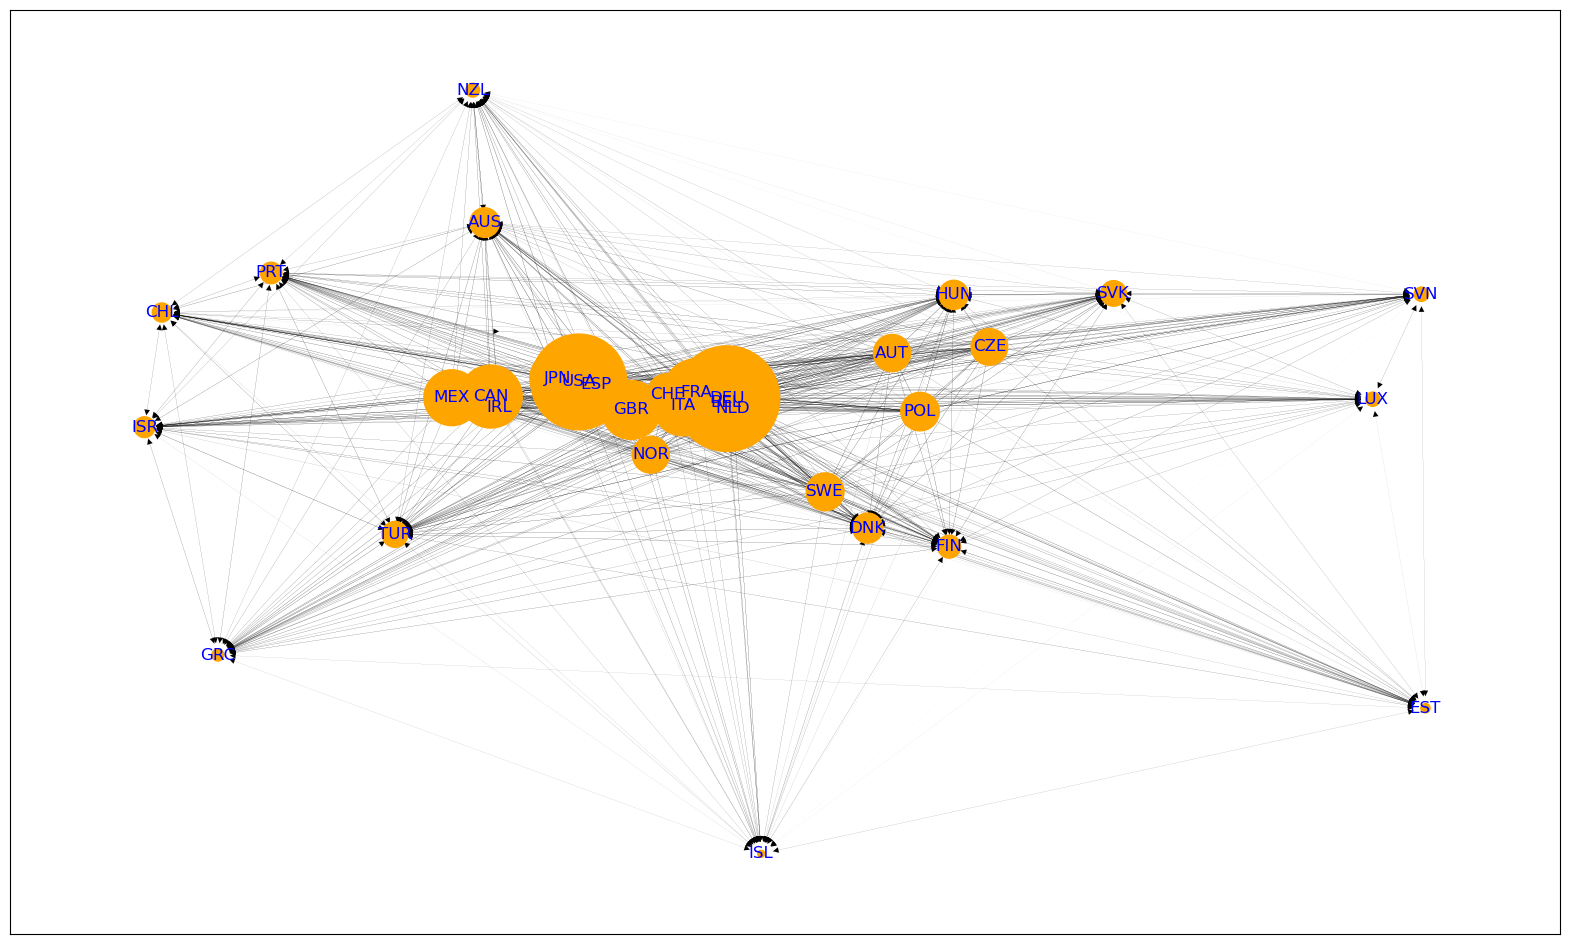

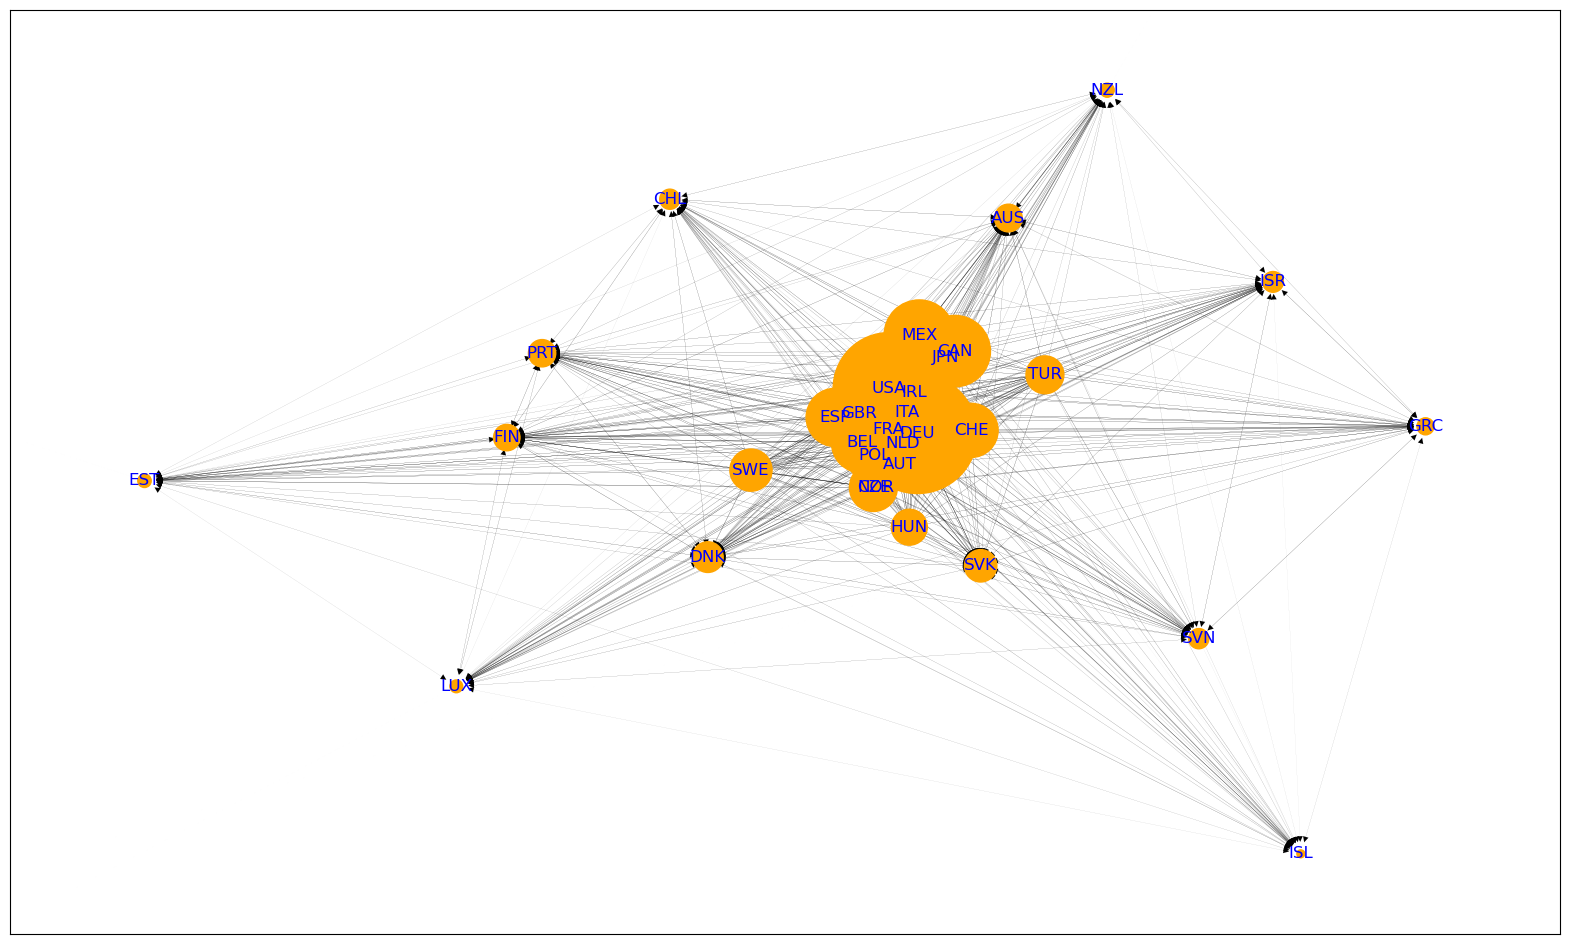

In [14]:
# Plot the old exports graph
plotGraph(gOld, exportsOld)

# Plot the new exports graph
plotGraph(gNew, exportsNew)

On the one hand, the main exporting countries -located in the center of the network- continue to dominate global exports, while the minor exporters have remained in the periphery. 
<p>
The main difference between the two graphs is a larger volume of exports between the countries that were already prime exporters in the first graph. In other words, the two separate clusters that could be distinguished in the first graph -representing the Central and North-American cluster, and the European cluster- have come together at the center of the second graph, merging into one cluster. This could be explained by the enhancement of transport technologies, which have allowed for the compression of time and space in an increasingly interconnected world. 
Indeed, there are three neighbouring countries -United States, Canada, and Mexico- that have mantained their trade relations.

# 4. Compute hubs and authorities

We first define a function `normalize(d)` to normalize the values of a dictionary `d`.

In [15]:
def normalize(d):
    
    # Calculate the sum of all values in the dictionary
    total_sum = sum(d.values())
    
    if total_sum == 0:
        return d  # Avoid division by zero
    else:
        norm_dict = {key: value / total_sum for key, value in d.items()} # Normalize each value
    
    return norm_dict

And test that the function works.

In [16]:
print(normalize({"a": 39, "b": 13, "c":26}))

{'a': 0.5, 'b': 0.16666666666666666, 'c': 0.3333333333333333}


Secondly, we create the function `hubs_authorities(g, weight_key)` to compute hubs and authorities scores using the edge key "weight" as a weight.

In [17]:
def hubs_authorities(g, weight_key="weight"):
    
    # Compute number of nodes in the graph
    num_nodes = len(g)

    # Initialize hub scores with 1/N for each country
    h = {node: 1 / num_nodes for node in g.nodes()}

    max_iterations = 100  # Maximum number of iterations

    for iteration in range(max_iterations):
        
        # Compute authority scores from hub scores
        a = {node: 0 for node in g.nodes()} # Initialize authority scores to 0
        for u, v, d in g.edges(data=True): # Only for edges with data
            a[v] += h[u] * d[weight_key] # Weighted sum of hub scores

        # Normalize authority scores
        a = normalize(a)

        # Compute hub scores from authority scores
        h = {node: 0 for node in g.nodes()}
        for u, v, d in g.edges(data=True):
            h[u] += a[v] * d[weight_key] # Weighted sum of authority scores

        # Normalize hub scores
        h = normalize(h)

    return h, a

In [18]:
print("Computing for {:d}".format(YEAR_OLD))
(hOld,aOld) = hubs_authorities(gOld)

print("Computing for {:d}".format(YEAR_NEW))
(hNew,aNew) = hubs_authorities(gNew)

Computing for 2010
Computing for 2021


And add columns `hOld`, `aOld`, `hNew`, and `aNew` to DataFrame `flowsDF`.

In [19]:
flowsDF['hOld'] = pd.Series(hOld)
flowsDF['aOld'] = pd.Series(aOld)
flowsDF['hNew'] = pd.Series(hNew)
flowsDF['aNew'] = pd.Series(aNew)

flowsDF

,expOld,impOld,expNew,impNew,hOld,aOld,hNew,aNew
AUS,75635,85288,66228,98114,0.008856,0.013926,0.006655,0.010975
AUT,120131,133543,177134,173801,0.014193,0.025587,0.014627,0.023609
BEL,224624,298985,319464,363238,0.027980,0.046006,0.028065,0.037360
CAN,342352,310242,441451,387599,0.168261,0.056977,0.171425,0.045188
CHE,149601,174765,253904,262140,0.023950,0.031025,0.038084,0.031625
CHL,31615,24462,35069,35868,0.005778,0.004732,0.007503,0.004526
CZE,115923,97460,199125,151059,0.011601,0.014956,0.012639,0.017356
DEU,962139,761044,1235638,1056755,0.113262,0.071773,0.107235,0.067649
DNK,78310,66979,81521,92344,0.008762,0.009422,0.005905,0.009110
ESP,192362,224917,294287,279927,0.021549,0.032318,0.021326,0.027793


In [20]:
# Sort the DataFrame by exports in descending order and get the top 10
top_exports = flowsDF.sort_values(by='expNew', ascending=False).head(10)

# Sort the DataFrame by hub score in descending order and get the top 10
top_hubs = flowsDF.sort_values(by='hNew', ascending=False).head(10)

# Convert country id to country name using the id2name dictionary
top_exports['Country'] = top_exports.index.map(id2name)
top_hubs['Country'] = top_hubs.index.map(id2name)

# Print the top 10 countries by exports
print("Top 10 countries by exports:")
print(top_exports[['Country', 'expNew']])

# Print the top 10 countries by hub score
print("\nTop 10 countries by hub score:")
print(top_hubs[['Country', 'hNew']])

Top 10 countries by exports:
            Country   expNew
DEU         Germany  1235638
USA   United States  1087703
NLD     Netherlands   515568
FRA          France   472845
ITA           Italy   462666
CAN          Canada   441451
MEX          Mexico   427071
GBR  United Kingdom   340783
BEL         Belgium   319464
ESP           Spain   294287

Top 10 countries by hub score:
            Country      hNew
MEX          Mexico  0.174192
CAN          Canada  0.171425
DEU         Germany  0.107235
JPN           Japan  0.066476
USA   United States  0.053119
ITA           Italy  0.045930
FRA          France  0.042137
NLD     Netherlands  0.040724
GBR  United Kingdom  0.039428
CHE     Switzerland  0.038084


In order to easily explain the difference between the total number of exports and the hub score parameters, we will analyse the case of Mexico. Even though it is in the seventh position regarding the total number of exports, it is the country with highest hub score. <p> Thus, the number of exports simply quantifies the monetary value of the output of a country to foreign markets. The hub score, however, is an indicator of a country's global influence within the trade network. <br>Indeed, the latter measures the importance of a country in terms of its centrality -for instance, a country will have high hub score if it is connected to many high-exporting countries, but it does not have to be a high-exporting country itself. 

In [21]:
# Sort the DataFrame by imports in descending order and get the top 10
top_imports = flowsDF.sort_values(by='impNew', ascending=False).head(10)

# Sort the DataFrame by authority score in descending order and get the top 10
top_auths = flowsDF.sort_values(by='aNew', ascending=False).head(10)

# Convert country id to country name using the id2name dictionary
top_imports['Country'] = top_imports.index.map(id2name)
top_auths['Country'] = top_auths.index.map(id2name)

# Print the top 10 countries by imports
print("Top 10 countries by imports:")
print(top_imports[['Country', 'impNew']])

# Print the top 10 countries by authority score
print("\nTop 10 countries by authority score:")
print(top_auths[['Country', 'aNew']])

Top 10 countries by imports:
            Country   impNew
USA   United States  1552176
DEU         Germany  1056755
FRA          France   553572
GBR  United Kingdom   431212
NLD     Netherlands   429962
CAN          Canada   387599
ITA           Italy   382891
BEL         Belgium   363238
MEX          Mexico   343717
ESP           Spain   279927

Top 10 countries by authority score:
            Country      aNew
USA   United States  0.356655
DEU         Germany  0.067649
FRA          France  0.055717
NLD     Netherlands  0.047547
CAN          Canada  0.045188
GBR  United Kingdom  0.044409
MEX          Mexico  0.039727
ITA           Italy  0.038687
BEL         Belgium  0.037360
CHE     Switzerland  0.031625


In a similar way, the total number of imports and the authority score of a country should also be differentiated. Even though the distinction now is not as straightforward, it can be observed that Spain occupies the tenth position in the top importing countries, but it does not appear in the list of countries with highest authority score. <p> In other words, a country with high imports merely acquires a large volume of goods from foreign countries, whereas a country with high authority score becomes a strategic trading partner, as it attracts exports from several foreign countries.  

# 5. Comparison of hub/export, authority/import scores

Lastly, to better understand the relation between the hub score and the number of exports, and between the authority score and the number of imports, we will illustrate a scatter plot in a log-log scale. To do so, we will use the function `plot_scatter(a, b, x_label, y_label)`.

In [22]:
# Function to create a log-log scatter plot
def plot_scatter(a, b, x_label, y_label):

    plt.figure(figsize=(20, 10))
    plt.loglog()
    # Add labels to the x axis and y axis
    plt.xlabel(x_label, {'size': '22'})
    plt.ylabel(y_label, {'size': '22'})
    
    # Add a diagonal line
    plt.plot([min(a.values()), max(a.values())], [min(b.values()), max(b.values())], '-.', lw=2)

    # Do the scatter plot with texts
    for country in set(a.keys()).intersection(set(b.keys())):
        plt.text(a[country], b[country], country, {'size': '12'})

    plt.show()

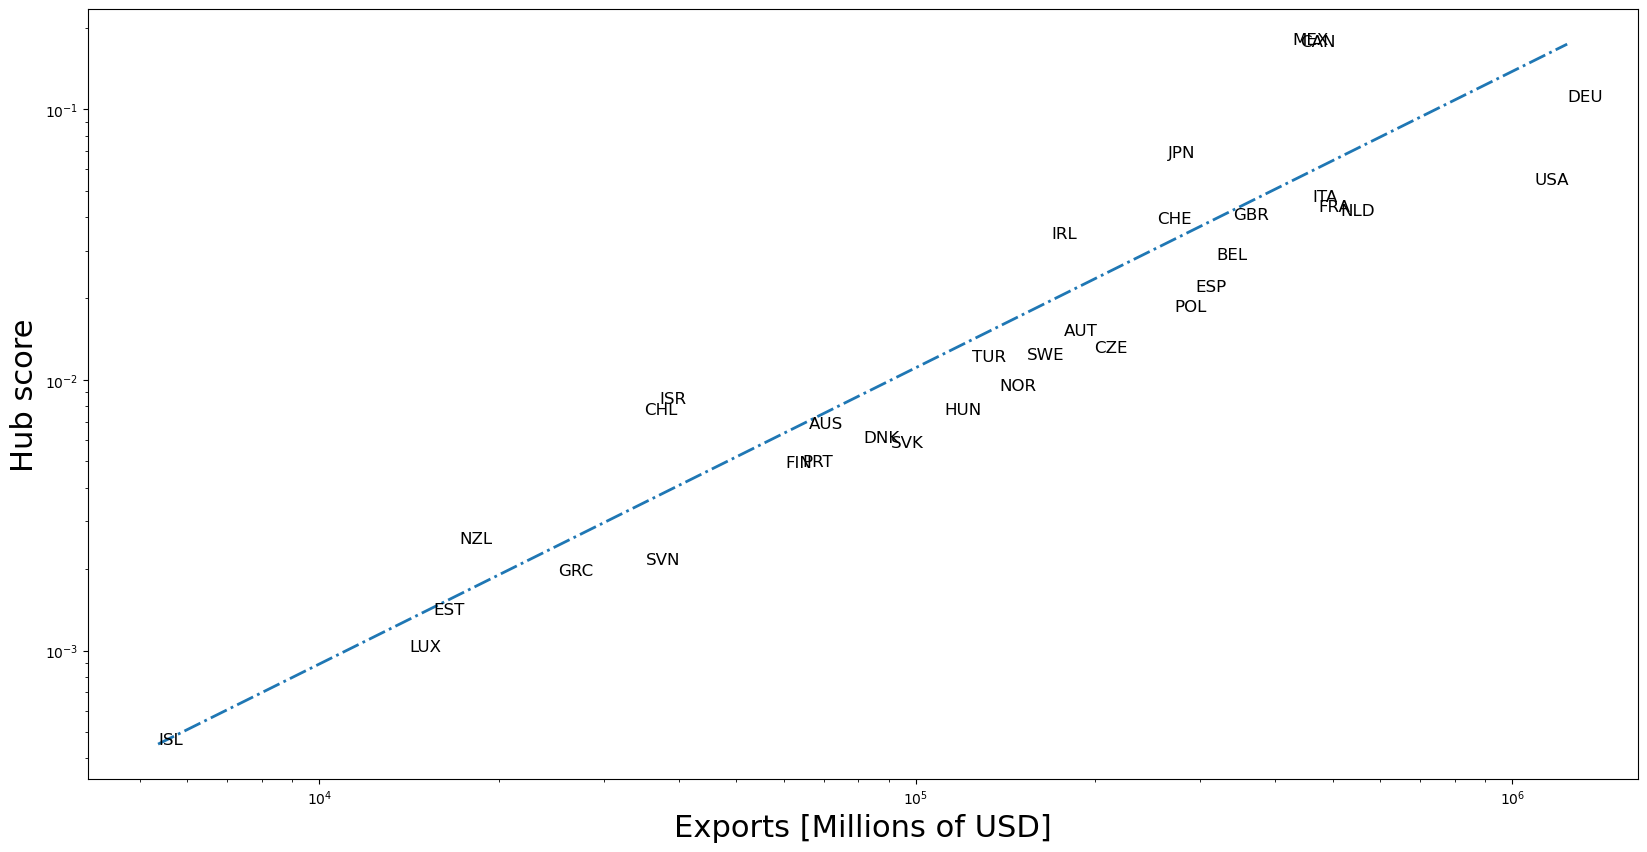

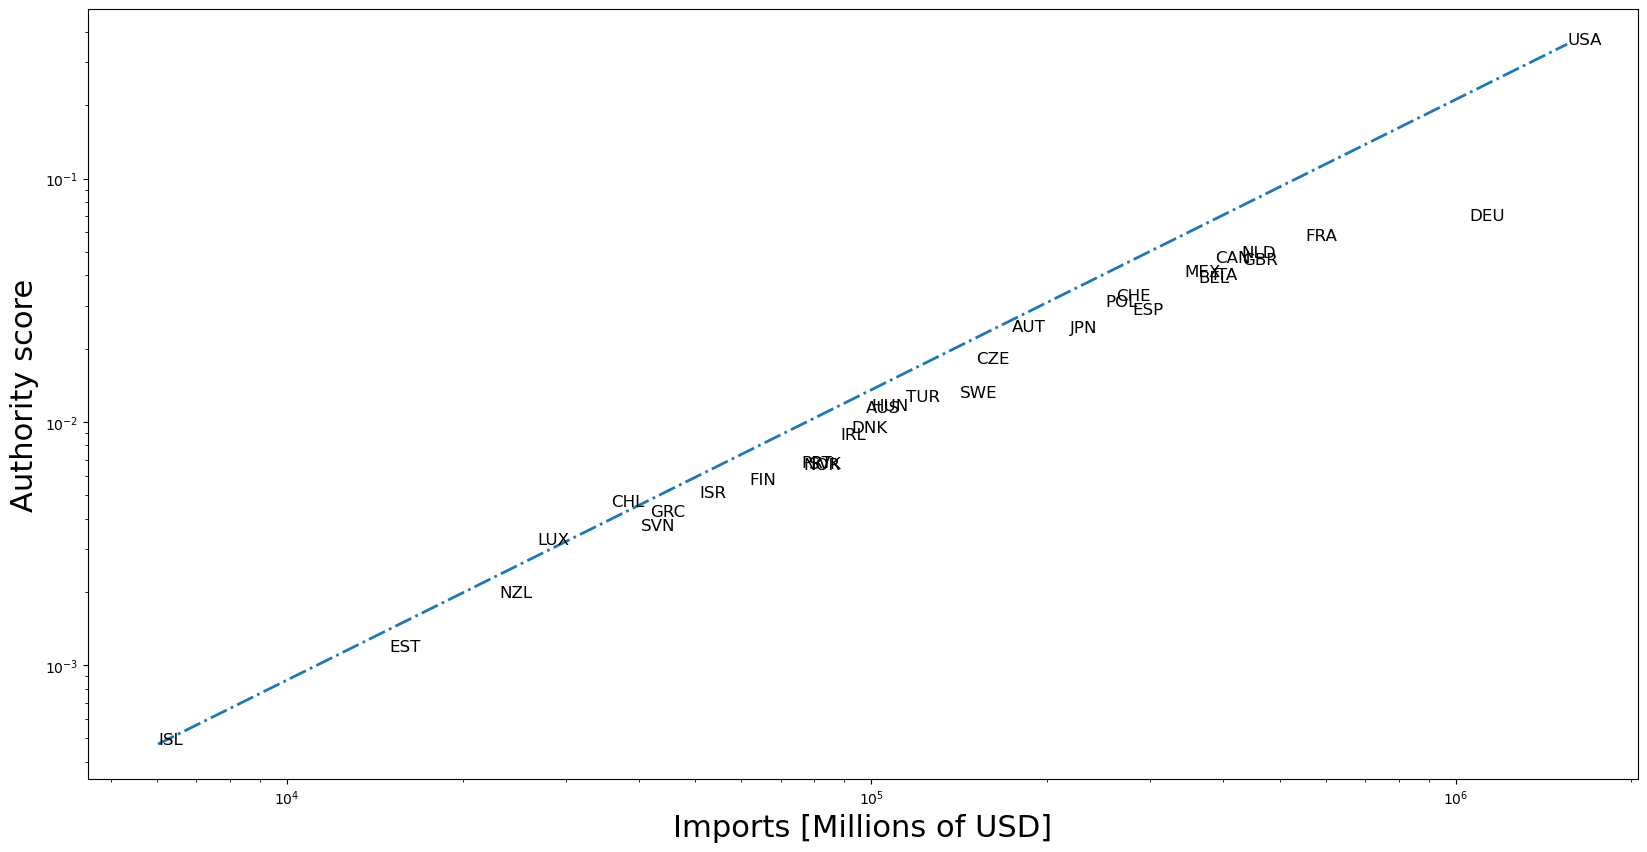

In [23]:
plot_scatter( exportsNew, hNew, "Exports [Millions of USD]", "Hub score" )
plot_scatter( importsNew, aNew, "Imports [Millions of USD]", "Authority score" )

Comparing the hub score with the total number of exports can be a key tool to identify potential critical actors in the trade network. Countries significantly above the diagonal line -which indicates proportionality between the country's hub score and its total exports- have relatively high hub scores compared to their exports. As a result, countries such as Mexico, Canada, and Israel exercise a big influence on the network despite their export levels. <p> The comparison between the hub score and the number of imports, however, does not reveal such clear results. Indeed, most countries are located cose to the diagonal, which indicates that their authority scores and imports are related in a proportional manner. What is more, those countries at a largest distance from the diagonal -like Germany- are located below the diagonal, indicating that they have low  authority score relative to their import levels.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>